# Principles of Machine Learning Lecture: Visualizing Learnt Weights


The focus of this notebook is to visualize the learning process and the learnt weights of a Perceptron (one of the first neural synapse inspired ML algorithms).

It is well suited to serve as an entry point to ML due to its simplicity. 


There are multiple cells pre-configured to set up the exercises of this notebook:

* Trainig Material will load MNIST and create a binary set for '0' and '1' handwritten digit classification
* Perceptron is an implementation of Perceptron (slightly adapted to the exercises)
* Visualizing the semantics of the dimensions already holds code for visualising the input sample and the weight vector
* Accuracy on the Training Set allows you to calculate the Training Set Accuracy






# Training Material

### MNIST Dataset

In order to start testing our Perceptron implementation we will move to a different and more realistially sized MNIST dataset.

We have already used the MNNIST dataset in the last semester when we started to familiarize us with the Machine Learning workflow.

"MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image." (source: http://yann.lecun.com/exdb/mnist/)

To save you some time the following cell contains code to download and sort the dataset. 

In [13]:
import numpy as np
# Download and sort the dataset

# Sorts the dataset by target (i.e the numbers 0-9). Sorts only the first 60000 entries (the training set).
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]


# Download and sort the dataset
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]


print(mnist.target.shape)
print(mnist.data.shape)

from sklearn.utils import shuffle


# Select 5000 values for 0 and 1 each by manually checking the boundaries or by checking for target value.
mnist_0_target = mnist.target[0:5000]
mnist_0_data = mnist.data[0:5000]
mnist_1_target = mnist.target[6000:11000]
mnist_1_data = mnist.data[6000:11000]
mnist_bin_0_1_data = np.concatenate((mnist_0_data, mnist_1_data))
mnist_bin_0_1_target = np.concatenate((mnist_0_target, mnist_1_target))
mnist_bin_0_1_target = np.where(mnist_bin_0_1_target == 0, -1, 1)

# Shuffle should be something that the students have to identify as an element that impacts the learning
X, y = shuffle(mnist_bin_0_1_data, mnist_bin_0_1_target)
len(mnist_bin_0_1_data)


(70000,)
(70000, 784)


10000

## 1. Perceptron class

We will use the so called Perceptron class for the classification.
The class is capable of doing binary classification and provides the following methods:

* fit: train the Perceptron
* net_input: calculate the net_input
* predict: make a prediction based on a sample input


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os


import numpy.random
from matplotlib._cm_listed import cmaps

class Perceptron(object):
    
    """Perceptron binary classifier.

    Parameters
    -----------
    eta : float
       Learning rate (value between 0.0 and 1.0)
    epochs  : int
       Number of passes over the training set

    Attributes
    -----------
    w_  : 1d-array
       Weights after fitting.
    errors_   : list
       Number of updates (triggered by prediction != target)

    """

    def __init__(self, eta=0.01, epochs=10, random_state=1):
        self.eta = eta
        self.epochs = epochs
        self.random_state = random_state
        # this initialize the weights
        rgen = numpy.random.RandomState(self.random_state)
        self.w_ = rgen.uniform(low=0.0, high=0.01, size=1 + X.shape[1])   
        
 

    def fit(self, X, y, draw, heatmap):
        """ Fit training data; i.e. train the Perceptron

        Parameters
        -----------
        X : dataframe with shape - [n_samples, n_features]
          feature vectors, where n_samples is the number of samples
          in the data set, n_features is the number of features
        y : dataframe with shape = [n_samples].
            1 target value per sample (the label).

        Returns
        -----------
        self : object

        """
        

        # this will be used to store the number of updates per epoch
        self.errors_ = [None] * self.epochs
        self.prec = [None] * self.epochs

        for epoch in range(self.epochs):
            errors = 0
            for xi, target in zip(X, y):
                error = target - self.predict(xi)
                if (error != 0): 
                    update = self.eta * (error)
                    self.w_[1:] += update * xi
                    self.w_[0] += update
                    draw_weight_vector(xi, self.w_, True)
                    errors += int(update != 0.0)
            self.errors_[epoch] = errors
            self.prec[epoch] = accuracy_on_train()
        return self

    def net_input(self, x):
        """Calculate net input"""
        net_input = np.dot(x, self.w_[1:]) + self.w_[0]
        return net_input

    def predict(self, x):
        """Predict based on computing the net input and the threshold function"""
        net_input = self.net_input(x)
        if net_input >= 0.0:
            prediction = 1
        elif net_input < 0.0:
            prediction = -1
        return prediction

# Visualizing the semantics of the dimensions.

The next cell contains an implementation that allows us 
to visualize the dimensions of the weight vector learnt by the 
Perceptron based on projecting back into the 2D space. 

In [34]:
%matplotlib inline
import numpy as np
from IPython.display import clear_output
from time import sleep
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as col
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

plt.rcParams["figure.figsize"] = 16,14
N=256
zero_pt0 = 0.5
zero_pt_rounded = np.ceil(zero_pt0*(N-1))/float(N-1)

cmap_rdbu = plt.get_cmap("RdBu")
cmap_rdbu.set_bad(color='white')

def draw_weight_vector(x, weight_vector, redraw):
    transf_weight_vector = np.copy(weight_vector[1:])
    transf_weight_vector = np.ma.masked_where(abs(transf_weight_vector) < 0.035, transf_weight_vector)
    #transf_weight_vector[np.abs(transf_weight_vector) < 1] = 0.5
    some_digit_image =  transf_weight_vector.reshape(28, 28)
    input_sample = x.reshape(28,28)
    
    
    gs = gridspec.GridSpec(3, 2)

    fig = plt.figure()
    ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
    ax1.axis("off")
    ax1.imshow(input_sample, cmap='gray', interpolation="nearest")
    
    ax2 = fig.add_subplot(gs[0, 1]) # row 0, col 1
    ax2.axis("off")
    ax2.imshow(some_digit_image, cmap_rdbu, interpolation="nearest")

    ax3 = fig.add_subplot(gs[1, :]) # row 1, span all columns
    ax3.plot(range(1, ppn.epochs + 1), ppn.errors_, marker='o')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Number of updates')
    
    ax4 = fig.add_subplot(gs[2, :]) # row 1, span all columns
    ax4.plot(range(1, ppn.epochs + 1), ppn.prec, marker='o')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    
    plt.show()
    sleep(0.1) #Fix sleep here
    if redraw:
        clear_output(wait=True)
    mpl.pyplot.close()
    
    
    
def draw_sample(x):
    
    input_sample = x.reshape(28,28)
    fig = plt.figure()
    plt.axis("off")
    plt.imshow(input_sample, cmap='gray', interpolation="nearest")
    plt.show()
    sleep(0.1)
    clear_output(wait=True)
    mpl.pyplot.close()


def draw_weights(x, redraw = False):
    transf_weight_vector = np.copy(x)
    transf_weight_vector = np.ma.masked_where(abs(transf_weight_vector) < 1, transf_weight_vector)
    some_digit_image =  transf_weight_vector.reshape(28, 28)
    fig_weights = plt.figure()
    plt.axis("off")
    plt.imshow(some_digit_image, cmap_rdbu, interpolation="nearest")
    plt.show()
    sleep(0.1)
    if redraw:
        clear_output(wait=True)
        mpl.pyplot.close()
    
    
    
    

## Visualizing the Training Process

Executing the cell below visualizes the training process.

Training Finished


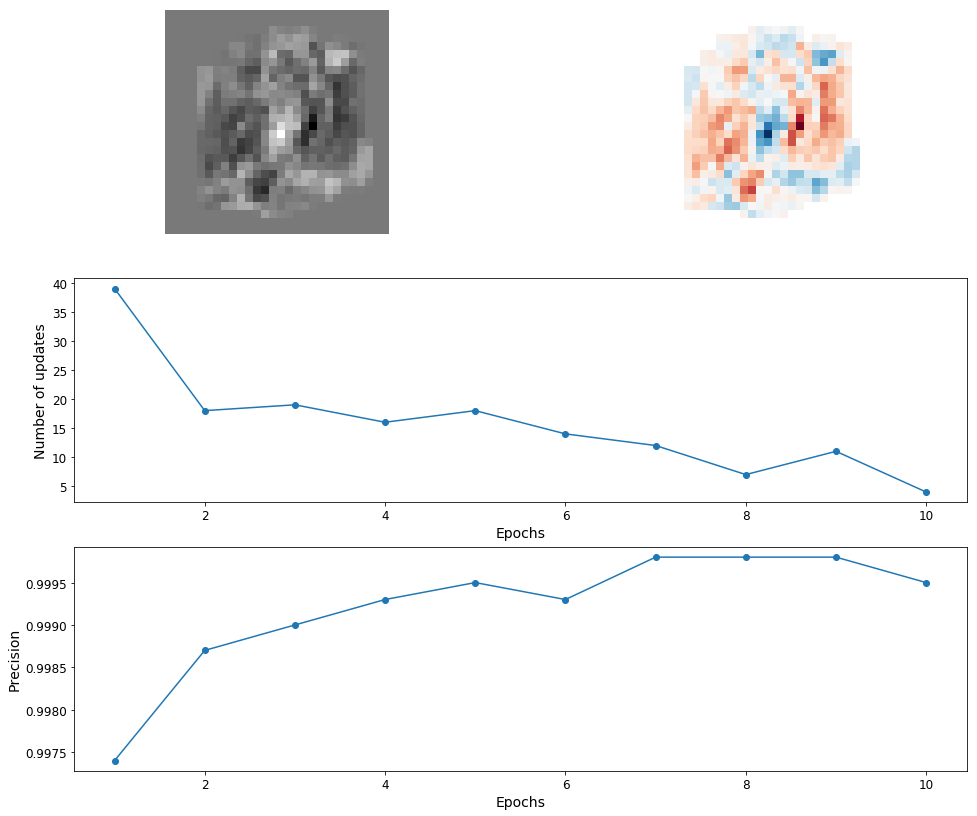

In [36]:
ppn = Perceptron(eta=10000, epochs=10)
ppn.fit(X,y, True, False)

print('Training Finished')
draw_weight_vector(ppn.w_[1:], ppn.w_, False)


## Accuracy on the Training Set

In [30]:
from sklearn.metrics import accuracy_score

def accuracy_on_train():
    y_pred = []
    y_true = []

    for i in range(0,10000):
        y_pred.append(ppn.predict(X[i]))
        y_true.append(y[i])

    training_data_score = accuracy_score(y_true, y_pred)
    return training_data_score


print(f"Accuracy score on training data: {accuracy_on_train()}")

def accuracy_on_test():
    y_pred = []
    y_true = []

    for i in range(60000,61950):
        y_pred.append(ppn.predict(mnist.data[i]))
        y_true.append(np.where(mnist.target[i]== 0, -1, 1))


    training_data_score = accuracy_score(y_true, y_pred)
    return training_data_score


print(f"Accuracy score on test data: {accuracy_on_test()}")

Accuracy score on training data: 0.9974
Accuracy score on test data: 0.9994871794871795


## Identifying mis-classified samples

The cell below is focused on collecting a set of missclassified samples for further analysis. Commonly when developing ML models, a first step after the establishment of the base line is to dig into the mis-classified material.



In [28]:
fp_samples = []
for i in range(60000,61950):
    true_value = mnist.target[i]
    predicted_value = 0 if ppn.predict(mnist.data[i]) == -1 else 1
    if (true_value != predicted_value):
        fp_samples.append(i)
        print(f"Predicted: {predicted_value} True: {true_value}")
    
print(len(fp_samples))

Predicted: 1 True: 0
1


0


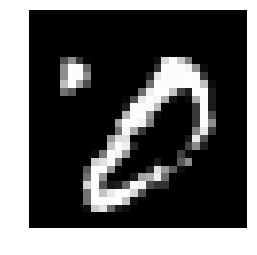

In [31]:
%matplotlib inline


for fp in fp_samples:
    print(mnist.target[fp])
    draw_sample(mnist.data[fp])


## Identifying the input that 'contributed' to the model's decision

The following implementation allows us to visualize the involved features and their degree of contribution.

* The first cell calculates the activation pattern on a given sample.
* The second cell can be used to loop over the false positive samples we have identified


In [32]:
def calculate_activation(x):
    activation = []

    for t in zip(x, ppn.w_[1:]):
        activation.append([t[0]*t[1]])
    
    return activation




True Value: 0
Net Value: 30855580137.402534


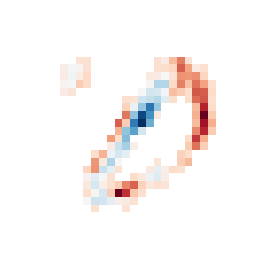

In [33]:
%matplotlib inline

for fp in fp_samples:
    act = calculate_activation(mnist.data[fp])
    print(f"True Value: {mnist.target[fp]}")
    print(f"Net Value: {ppn.net_input(mnist.data[fp])}")
    draw_weights(np.array(act))
    

    
    